# 02_EDA

Structure
- Notebook Preparation

- [View & Learn Data](##view--learn-data)

- [Clean & Organise Data](##clean--organise-data)
    - Segregate by 'Winter' months
    - Identify Stations in European Alps
    - Data Filtering
    - Assess Data Validity
        - Focus Range
        - Filter by Country
        - Filter by Elevation Band

- [Statistical Testing](##statistical-testing)



## Notebook Preparation

In [57]:
# Import Packages

import pandas as pd
import numpy as np
import plotly
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
import plotly.express as px
import geopandas as gpd
import rasterio
from rasterio.plot import show
from rasterio.mask import mask
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pymannkendall as mk
from pathlib import Path


In [58]:
# Files & Directories

NB_DIR = Path.cwd()         # Notebook Directory
REPO_ROOT = NB_DIR.parent   # Main Directory

## View & Learn Data

In [59]:
# Import Metadata
metadata = pd.read_csv(REPO_ROOT/'Data/Cleaned/weather_stations_list.csv')

metadata.head()

,station_id,name,latitude,longitude,elevation,country,provider
0,2979,Cap_ferrat,43.68333,7.32367,138,France,FR_METEOFRANCE
1,2978,Les_orres_fontaines,44.47567,6.55767,1895,France,FR_METEOFRANCE
2,2977,Broc,46.60966,7.10816,682,Switzerland,CH_METEOSWISS
3,2976,Mesocco,46.39560,9.23108,825,Switzerland,CH_METEOSWISS
4,2975,Dischingen_Eglingen,48.71340,10.44050,550,Germany,DE_DWD


In [60]:
# Import Station Data 
station_data = pd.read_csv(REPO_ROOT/'Data/Cleaned/monthly_snowpack.csv')

station_data.head()

,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


In [61]:
# Station Data Info
print('Station Data Info')
print(station_data.info())
print('')

print(f'Station Data Shape {station_data.shape}')

print(f'Number Of Unique Entries = {station_data['id'].nunique()} ')

Station Data Info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500100 entries, 0 to 1500099
Data columns (total 5 columns):
 #   Column      Non-Null Count    Dtype  
---  ------      --------------    -----  
 0   id          1500100 non-null  int64  
 1   station_id  1500100 non-null  int64  
 2   year        1500100 non-null  int64  
 3   month       1500100 non-null  int64  
 4   hnsum       1027301 non-null  float64
dtypes: float64(1), int64(4)
memory usage: 57.2 MB
None

Station Data Shape (1500100, 5)
Number Of Unique Entries = 1500100 


In [62]:
# Drop Null Values
station_data = station_data.dropna()

station_data.describe(include='all')


,id,station_id,year,month,hnsum
count,1.027301e+06,1.027301e+06,1.027301e+06,1.027301e+06,1.027301e+06
mean,1.068072e+06,1.489530e+03,1.990848e+03,6.405561e+00,1.941337e+01
std,4.381786e+05,8.584716e+02,1.802231e+01,3.521692e+00,3.985992e+01
min,3.714010e+05,1.000000e+00,1.864000e+03,1.000000e+00,0.000000e+00
25%,6.808710e+05,7.560000e+02,1.980000e+03,3.000000e+00,0.000000e+00
50%,1.045491e+06,1.494000e+03,1.993000e+03,6.000000e+00,0.000000e+00
75%,1.404724e+06,2.235000e+03,2.004000e+03,1.000000e+01,2.100000e+01
max,1.871500e+06,2.979000e+03,2.020000e+03,1.200000e+01,8.270000e+02


In [63]:
station_data.head()

,id,station_id,year,month,hnsum
0,371401,2249,1996,3,39.0
1,371402,2249,1997,1,99.0
2,371403,2249,1997,2,22.0
3,371404,2249,1997,3,7.0
4,371405,2249,1998,1,84.0


## Clean & Organise Data

### Segregate by 'Winter' months

In [64]:
# Assess 'Winter Months' between November - April

station_data['winter'] = station_data['month'].isin([11, 12, 1, 2, 3, 4, 5])

# Validate new column values

print('Number Of Winter Month Records = ',sum(station_data[station_data['winter']==True].value_counts()))

print('Number Of Summer Month Records =',sum(station_data[station_data['winter']==False].value_counts()))

print('Total Number Of Records = ',station_data.value_counts().sum())

Number Of Winter Month Records =  626049
Number Of Summer Month Records = 401252
Total Number Of Records =  1027301


### Identify Stations In European Alps



In [65]:

gdf_alps = gpd.read_file(REPO_ROOT /"Data/Raw/boundary_alps/AlpineConvention.shp")

gdf_alps

,OBJECTID,AREA,PERIMETER,NUEU1MV8_,NUEU1MV8_I,NUFTTP,NURGCDL3,NURGCDL2,NURGCDL1,NUCNCD,...,ROWID_1,ADCNCD,ADCNNM,ADCNPSEU,ADCNPSEF,ADCNPSCC,ADCNPSOC,SHAPE_Leng,SHAPE_Area,geometry
0,6830,0.398094,4.501714,8614,8676,M,AT213,AT21,AT2,AT,...,13,AT,AUSTRIA,T,F,F,F,4.501719,0.398094,"MULTIPOLYGON (((3893174.789 2365660.083, 38932..."


In [66]:
# Convert DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(metadata["longitude"], metadata["latitude"])]
gdf_proj = gpd.GeoDataFrame(metadata, geometry=geometry, crs="EPSG:4326")  # WGS84 lat/lon


In [67]:
# Reproject station points to match the Alpine boundary CRS
gdf_proj = gdf_proj.to_crs(gdf_alps.crs)

# Filter station points inside Alpine region
stations_in_alps = gdf_proj[gdf_proj.within(gdf_alps.geometry.union_all())]

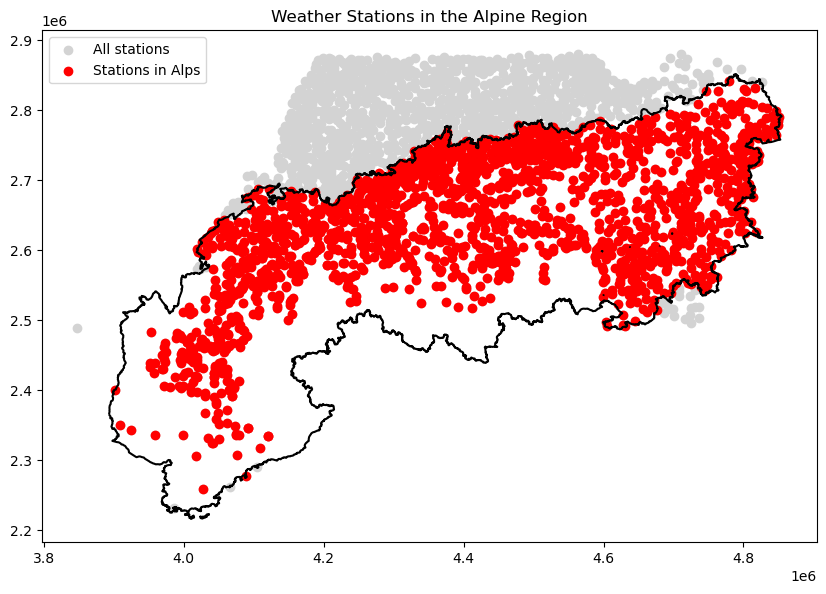

In [68]:
# Matplotlib Visualisation

fig, ax = plt.subplots(figsize=(10, 10))
gdf_alps.boundary.plot(ax=ax, edgecolor='black')
gdf_proj.plot(ax=ax, color='lightgray', label='All stations')
stations_in_alps.plot(ax=ax, color='red', label='Stations in Alps')
plt.legend()
plt.title("Weather Stations in the Alpine Region")
plt.show()


In [69]:
stations_in_alps

,station_id,name,latitude,longitude,elevation,country,provider,geometry
1,2978,Les_orres_fontaines,44.47567,6.55767,1895,France,FR_METEOFRANCE,POINT (4046677.268 2380186.742)
2,2977,Broc,46.60966,7.10816,682,Switzerland,CH_METEOSWISS,POINT (4099303.032 2615017.985)
3,2976,Mesocco,46.39560,9.23108,825,Switzerland,CH_METEOSWISS,POINT (4261799.553 2587236.844)
7,2972,Prapoutel_38002404,45.25000,5.97467,1840,France,FR_METEOFRANCE,POINT (4004665.394 2468305.539)
8,2971,Val_casterino,44.09183,7.50350,1554,France,FR_METEOFRANCE,POINT (4120669.706 2334651.739)
...,...,...,...,...,...,...,...,...
2783,12,Podgorje,46.70639,15.81972,230,Slovenia,SI_ARSO,POINT (4765952.237 2638897.47)
2784,10,Sv_duh_na_ostrem_vrhu,46.61325,15.46336,870,Slovenia,SI_ARSO,POINT (4739498.012 2626504.276)
2786,8,Kozji_vrh,46.59917,15.26750,340,Slovenia,SI_ARSO,POINT (4724631.143 2623859.326)
2791,3,Megeve,45.85317,6.60483,1080,France,FR_METEOFRANCE,POINT (4057059.628 2532728.861)


### Data Filtering

Filter snowpack_depth recordings by Weather Stations In European Alps

In [70]:
# Create list of European Alp Weather Stations
stations_in_alps_list = stations_in_alps['station_id']

# Filter station_data to Weather Stations in Alps
station_data = station_data[station_data['station_id'].isin(stations_in_alps_list)]



### Assess Data Validity

Determine which years within our dataset meet thresholds to consider analysis

- Standard Error (SE) / Confidence Intervals
- Minimum Sample Size
    - Size = 30
- Coefficient of Variation (CV)
    - Compares the variability to the mean.
    - High CV in low-sample years means those averages are unstable.

Span of continuous reliable years: 1936 - 2019


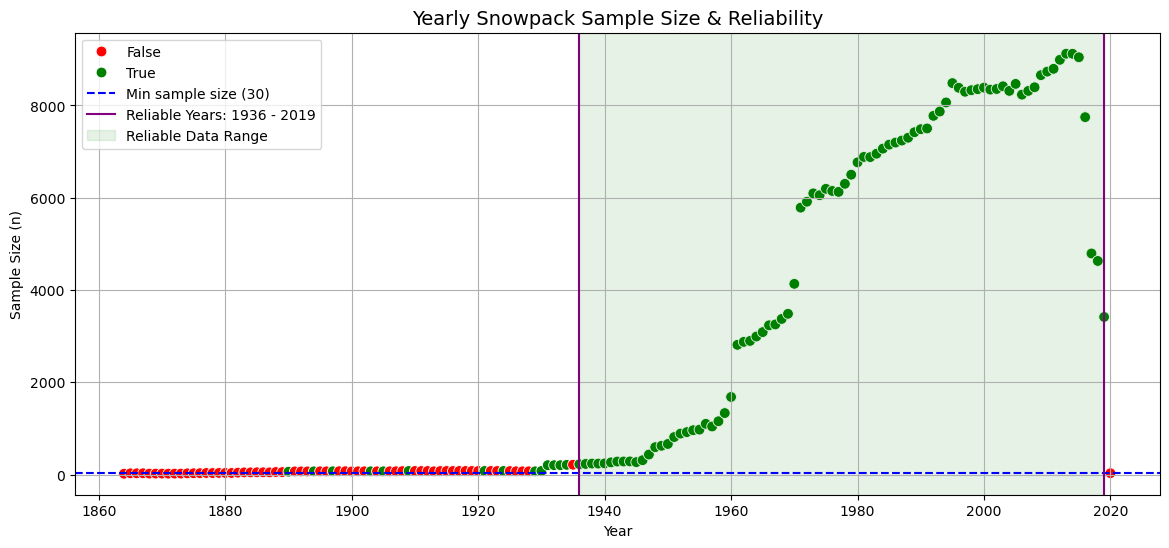

,year,n,mean,std,SE,CV,mean_change,Reliable
0,1864,18,20.333333,32.526912,7.666667,1.599684,NaN,False
1,1865,27,24.555556,34.562467,6.651550,1.407521,0.207650,False
2,1866,27,39.185185,46.071881,8.866538,1.175747,0.595777,False
3,1867,28,34.392857,52.411717,9.904884,1.523913,0.122299,False
4,1868,21,32.523810,45.706257,9.973923,1.405317,0.054344,False
...,...,...,...,...,...,...,...,...
152,2016,7747,35.948367,50.611129,0.575015,1.407884,0.380874,True
153,2017,4792,46.435518,53.500527,0.772858,1.152147,0.291728,True
154,2018,4630,41.489201,58.425804,0.858646,1.408217,0.106520,True
155,2019,3416,45.271663,54.456242,0.931727,1.202877,0.091167,True


In [71]:
# Assistance With AI

#  Aggregate Yearly Stats for Snowpack Depth
yearly_stats = station_data[station_data['winter']==True].groupby('year').agg(
    n=('hnsum', 'size'),
    mean=('hnsum', 'mean'),
    std=('hnsum', 'std')
).reset_index()

# Calculate Standard Error (SE) and Coefficient of Variation (CV)
yearly_stats['SE'] = yearly_stats['std'] / np.sqrt(yearly_stats['n']) # SE = Standard Deviation / (Square root of Sample size)
yearly_stats['CV'] = yearly_stats['std'] / yearly_stats['mean'] # CV = Standard Deviation / Average 

# Calculate year-to-year % change in mean snow depth
yearly_stats['mean_change'] = yearly_stats['mean'].pct_change().abs()

# Set Data Validity thresholds
min_sample_size = 30  # Minimum number of recordings per year
max_se_threshold = yearly_stats['SE'].median() * 1.5  # Allow 50% above median SE
mean_change_threshold = yearly_stats['mean'].mean() * 0.20  # 20% change allowed

# Assign Reliability flag
yearly_stats['Reliable'] = (
    (yearly_stats['n'] >= min_sample_size) &
    (yearly_stats['SE'] <= max_se_threshold) &
    (yearly_stats['mean_change'] <= mean_change_threshold)
)


# Assume yearly_stats['year'] is sorted
reliable_years = yearly_stats.loc[yearly_stats['Reliable'], 'year'].tolist()

# Identify an unbroken continous chain of 'Reliable Years' of data
earliest_reliable_year = None
latest_reliable_year = max(reliable_years) # Known Max() value is in continous chain
for i, start_year in enumerate(reliable_years):
    # Check if all years from start_year to max year are in the reliable list
    expected_years = list(range(start_year, max(reliable_years) + 1))
    if expected_years == reliable_years[i:]:
        earliest_reliable_year = start_year
        break

print(f"Span of continuous reliable years: {earliest_reliable_year} - {latest_reliable_year}")


# Plot
plt.figure(figsize=(14, 6))
sns.scatterplot(data=yearly_stats, x='year', y='n', hue='Reliable',
                palette={True: 'green', False: 'red'}, s=60)
plt.axhline(min_sample_size, color='blue', linestyle='--', label=f'Min sample size ({min_sample_size})')
plt.axvline(earliest_reliable_year, color='purple', linestyle='-', 
            label=f'Reliable Years: {earliest_reliable_year} - {latest_reliable_year}')
plt.axvline(latest_reliable_year, color='purple', linestyle='-')

# Shaded region for reliable years
plt.axvspan(earliest_reliable_year,latest_reliable_year, color='green', alpha=0.1,
            label="Reliable Data Range")

plt.title("Yearly Snowpack Sample Size & Reliability", fontsize=14)
plt.xlabel("Year")
plt.ylabel("Sample Size (n)")
plt.legend()
plt.grid(True)
plt.show()

# --- Output the yearly stats for review ---
yearly_stats


### Data Filtering

#### Focus Range
Use identifed Focus_Range to isolate chosen sample data 

In [72]:
# Segregate the identiied Focus_Range
focus_range = np.arange(earliest_reliable_year,latest_reliable_year +1)
snow_recordings = station_data[(station_data['year'].isin(focus_range)) & (station_data['winter'] == True)]

# Sort by choronlogical order
snow_recordings = snow_recordings.sort_values(by=['year', 'month','station_id']).reset_index(drop=True)

pd.DataFrame(snow_recordings)
snow_recordings.head(2)


,id,station_id,year,month,hnsum,winter
0,1784526,132,1936,1,37.0,True
1,1618609,153,1936,1,78.0,True


#### Filter By Country

In [73]:
snow_recordings = pd.merge(snow_recordings, stations_in_alps, on='station_id')
snow_recordings.head(2)

,id,station_id,year,month,hnsum,winter,name,latitude,longitude,elevation,country,provider,geometry
0,1784526,132,1936,1,37.0,True,Scuol_CH_METEOSWISS,46.79327,10.28324,1303,Switzerland,CH_METEOSWISS,POINT (4342645.19 2631133.413)
1,1618609,153,1936,1,78.0,True,Arosa_CH_METEOSWISS,46.79262,9.67900,1878,Switzerland,CH_METEOSWISS,POINT (4296468.91 2631072.969)


In [74]:
snow_recordings.value_counts('country')

country
Austria        144156
Switzerland     85486
Germany         64985
France          56400
Slovenia        43498
Italy           18482
Name: count, dtype: int64

### Filter by Elevation

#### Create Elevation Bands

In [75]:
snow_recordings['elevation'].describe()

count    413007.000000
mean        909.367081
std         497.885618
min           2.000000
25%         520.000000
50%         820.000000
75%        1227.000000
max        2964.000000
Name: elevation, dtype: float64

In [76]:
quartiles = np.quantile(snow_recordings['elevation'], [0.25, 0.5, 0.75])
Q1, median, Q3 = quartiles

def classify_elevation(elev):
    if elev <= Q1:
        return 'Low Elevation'
    elif Q1 < elev < Q3:
        return 'Mid Elevation'
    else:
        return 'High Elevation'
    
snow_recordings['elevation_band'] = snow_recordings['elevation'].apply(classify_elevation)

In [77]:
snow_recordings.head(2)

,id,station_id,year,month,hnsum,winter,name,latitude,longitude,elevation,country,provider,geometry,elevation_band
0,1784526,132,1936,1,37.0,True,Scuol_CH_METEOSWISS,46.79327,10.28324,1303,Switzerland,CH_METEOSWISS,POINT (4342645.19 2631133.413),High Elevation
1,1618609,153,1936,1,78.0,True,Arosa_CH_METEOSWISS,46.79262,9.67900,1878,Switzerland,CH_METEOSWISS,POINT (4296468.91 2631072.969),High Elevation


## Statistical Testing

### Mann_Kendal Test


- Output 
    - n : 
        - number of years tested for that group.
    - trend & p :
        - statistical significance of a monotonic increase/decrease.
    - tau :
        - strength of the monotonic relationship (direction via sign).
    - slope_per_year/decade :
        - estimated rate of change (Sen’s slope) in your units (e.g., cm of snow depth per year/decade).

In [78]:
# Empty Results List
results = []

# 1) aggregate: mean snow depth per month-year
month_year = (snow_recordings
              .groupby(['month', 'year'])['hnsum']
              .mean()
              .reset_index())

for m, g in month_year.groupby('month'):
    # 2) extract series for this month
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]

    if len(x) < 15:  # simple guard
        results.append({'month': m, 'n': len(x), 'trend': 'insufficient', 'p': np.nan,
                        'tau': np.nan, 'slope_per_year': np.nan})
        continue

    # 3) run MK (original)
    res = mk.original_test(x)

    # 4) store
    results.append({
        'month': m,
        'n': len(x),
        'trend': res.trend,
        'p': res.p,
        'tau': res.Tau,
        'slope_per_year': res.slope,
        'slope_per_decade': res.slope * 10
    })

mk_month_simple = pd.DataFrame(results).sort_values('month').reset_index(drop=True)
mk_month_simple


,month,n,trend,p,tau,slope_per_year,slope_per_decade
0,1,84,no trend,9.591463e-02,-0.123924,-0.219989,-2.199892
1,2,84,no trend,7.367775e-02,-0.133104,-0.216468,-2.164683
2,3,84,no trend,4.239084e-01,-0.059667,-0.093834,-0.938339
3,4,84,decreasing,9.754708e-03,-0.192197,-0.175994,-1.759943
4,5,84,decreasing,6.124619e-07,-0.370625,-0.104082,-1.040820
5,11,84,no trend,1.983007e-01,-0.095812,-0.104533,-1.045331
6,12,84,no trend,7.749138e-02,-0.131383,-0.250892,-2.508917


In [79]:

rows = []

# 1) aggregate: mean snow depth per (elev_band, month, year)
df_agg = (snow_recordings
          .groupby(['elevation_band','month','year'])['hnsum']
          .mean()
          .reset_index())

for (band, m), g in df_agg.groupby(['elevation_band','month']):
    # 2) series
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]

    if len(x) < 15:
        rows.append({'elevation_band': band, 'month': m, 'n': len(x),
                     'trend': 'insufficient', 'p': np.nan, 'tau': np.nan,
                     'slope_per_year': np.nan})
        continue

    # 3) MK (original to start; you can switch to hamed_rao if needed)
    res = mk.original_test(x)

    # 4) store
    rows.append({
        'elevation_band': band,
        'month': m,
        'n': len(x),
        'trend': res.trend,
        'p': res.p,
        'tau': res.Tau,
        'slope_per_year': res.slope,
        'slope_per_decade': res.slope * 10
    })

mk_elev_month_simple = pd.DataFrame(rows).sort_values(['elevation_band','month']).reset_index(drop=True)
mk_elev_month_simple


,elevation_band,month,n,trend,p,tau,slope_per_year,slope_per_decade
0,High Elevation,1,84,no trend,4.106004e-01,-0.061388,-0.180615,-1.806151
1,High Elevation,2,84,no trend,7.367775e-02,-0.133104,-0.299469,-2.994691
2,High Elevation,3,84,no trend,5.912889e-01,-0.040161,-0.106889,-1.068888
3,High Elevation,4,84,no trend,5.992793e-02,-0.139989,-0.245439,-2.454391
4,High Elevation,5,84,decreasing,1.521525e-07,-0.390132,-0.357722,-3.577219
5,High Elevation,11,84,no trend,2.544485e-01,-0.084911,-0.150217,-1.502166
6,High Elevation,12,84,no trend,3.208009e-01,-0.074010,-0.231329,-2.313291
7,Low Elevation,1,84,decreasing,1.271365e-02,-0.185313,-0.158870,-1.588699
8,Low Elevation,2,84,no trend,2.092961e-01,-0.093517,-0.072880,-0.728802
9,Low Elevation,3,84,no trend,9.568677e-01,0.004303,0.001111,0.011110


In [80]:

rows = []

# 1) aggregate: mean snow depth per (country, year)
df_agg = (snow_recordings
          .groupby(['country','year'])['hnsum']
          .mean()
          .reset_index())

for c, g in df_agg.groupby('country'):
    # 2) series
    g = g.sort_values('year')
    x = g['hnsum'].to_numpy(dtype=float)
    x = x[~np.isnan(x)]
    n = len(x)

    if n < 15:
        rows.append({'country': c, 'n': n, 'variant': 'original',
                     'trend': 'insufficient', 'p': np.nan, 'tau': np.nan,
                     'slope_per_year': np.nan})
        continue

    # 3b) MK Hamed–Rao (autocorr-adjusted)
    res2 = mk.hamed_rao_modification_test(x)
    rows.append({'country': c, 'n': n, 'variant': 'hamed_rao',
                 'trend': res2.trend, 'p': res2.p, 'tau': res2.Tau,
                 'slope_per_year': res2.slope, 'slope_per_decade': res2.slope*10})

mk_country_simple = pd.DataFrame(rows).sort_values(['country','variant']).reset_index(drop=True)
mk_country_simple


,country,n,variant,trend,p,tau,slope_per_year,slope_per_decade
0,Austria,47,hamed_rao,no trend,0.056165,-0.176688,-0.173407,-1.734072
1,France,61,hamed_rao,no trend,0.546094,0.053552,0.073091,0.730909
2,Germany,83,hamed_rao,no trend,0.531771,0.052013,0.052509,0.525091
3,Italy,48,hamed_rao,no trend,0.063226,-0.186170,-0.353379,-3.533788
4,Slovenia,59,hamed_rao,decreasing,0.007054,-0.241379,-0.170689,-1.706890
5,Switzerland,84,hamed_rao,no trend,0.065374,-0.137120,-0.106037,-1.060371


## Visualisations

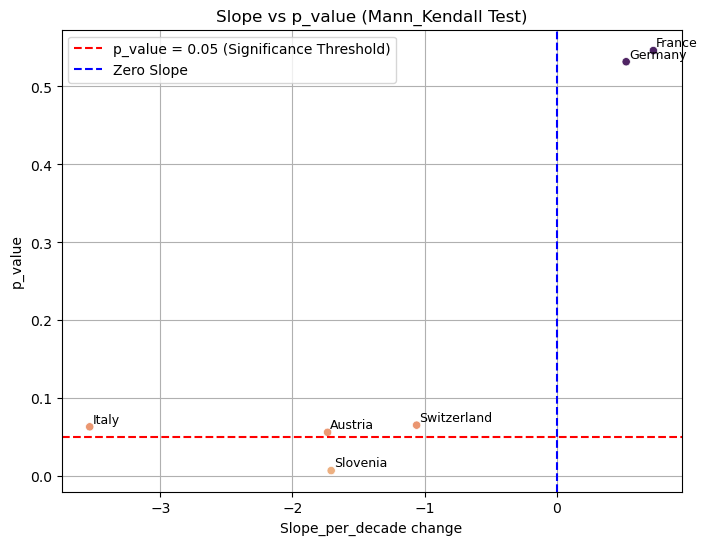

In [81]:
fig1, ax = plt.subplots(figsize=(8,6))


sns.scatterplot(data=mk_country_simple, x='slope_per_decade',y='p',hue='p',palette='flare',legend=False )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

# Annotate each point with the country name
for i, row in mk_country_simple.iterrows():
    ax.text(
        row['slope_per_decade'] + 0.02,  # x position slightly offset
        row['p'] + 0.005,                # y position slightly offset
        row['country'],
        fontsize=9
    )


ax.legend()
ax.set_ylabel('p_value')
ax.set_xlabel('Slope_per_decade change')
ax.set_title('Slope vs p_value (Mann_Kendall Test)')
ax.grid(True)

plt.show()

In [82]:
month_labels = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    11:'Nov',
    12:'Dec'
}

def get_month_name(month_number):
    """
    Converts a month number to an abbreviated month name using a custom dictionary

    Args:
        month_number (int): The number representing the month (1 for January, 12 for December).

    Returns:
        str: The abbreviated name of the month, or "Invalid month number" if out of range.
    """
    if 1 <= month_number <= 12:
        return month_labels[month_number]
    else:
        return "Invalid month number"


mk_month_simple['month_name'] = mk_month_simple['month'].apply(get_month_name)

mk_month_simple


,month,n,trend,p,tau,slope_per_year,slope_per_decade,month_name
0,1,84,no trend,9.591463e-02,-0.123924,-0.219989,-2.199892,Jan
1,2,84,no trend,7.367775e-02,-0.133104,-0.216468,-2.164683,Feb
2,3,84,no trend,4.239084e-01,-0.059667,-0.093834,-0.938339,Mar
3,4,84,decreasing,9.754708e-03,-0.192197,-0.175994,-1.759943,Apr
4,5,84,decreasing,6.124619e-07,-0.370625,-0.104082,-1.040820,May
5,11,84,no trend,1.983007e-01,-0.095812,-0.104533,-1.045331,Nov
6,12,84,no trend,7.749138e-02,-0.131383,-0.250892,-2.508917,Dec


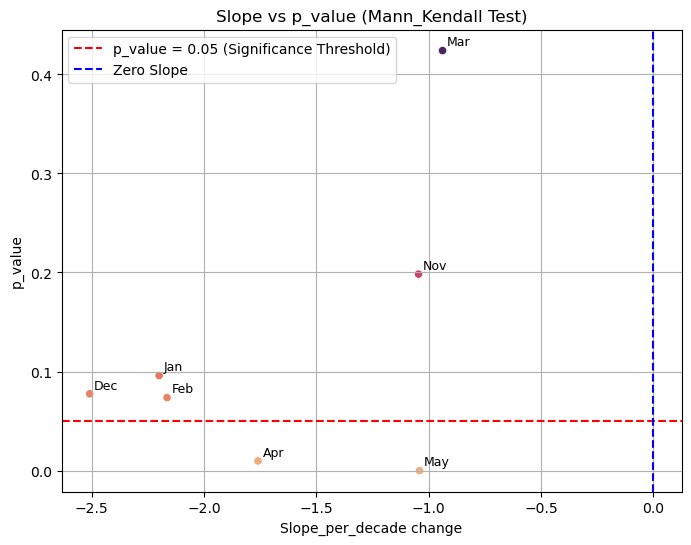

In [83]:

fig, ax = plt.subplots(figsize=(8,6))


sns.scatterplot(data=mk_month_simple, x='slope_per_decade',y='p',hue='p',palette='flare',legend=False )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

# Annotate each point with the month name
for i, row in mk_month_simple.iterrows():
    ax.text(
        row['slope_per_decade'] + 0.02,  # x position slightly offset
        row['p'] + 0.005,                # y position slightly offset
        row['month_name'],
        fontsize=9
    )


ax.legend()
ax.set_ylabel('p_value')
ax.set_xlabel('Slope_per_decade change')
ax.set_title('Slope vs p_value (Mann_Kendall Test)')
ax.grid(True)

plt.show()

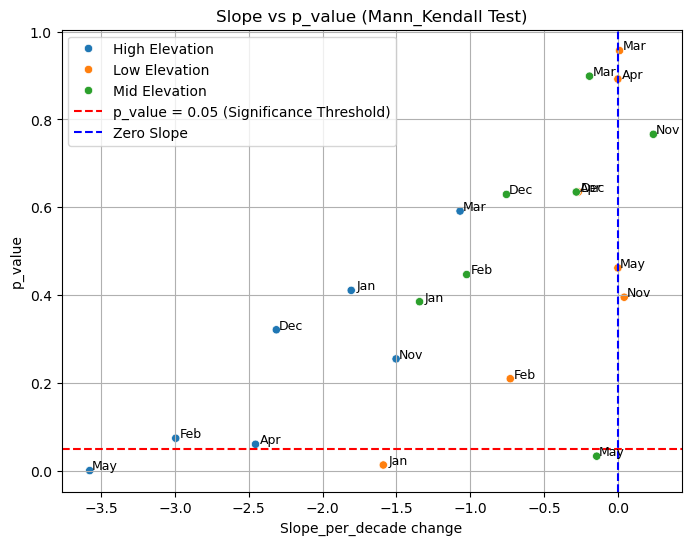

In [84]:
mk_elev_month_simple['month_name'] = mk_elev_month_simple['month'].apply(get_month_name)


fig2, ax2 = plt.subplots(figsize=(8,6))



sns.scatterplot(data=mk_elev_month_simple, x='slope_per_decade',y='p',hue='elevation_band', ax=ax2 )

plt.axhline(0.05,linestyle='--',color='red',label='p_value = 0.05 (Significance Threshold)')
plt.axvline(0.00,linestyle='--',color='blue',label='Zero Slope')

for i, row in mk_elev_month_simple.iterrows():
    ax2.text(
        row['slope_per_decade'] +0.1 ,
        row['p'] + 0.01,
        row['month_name'],        # Display month
        fontsize=9,
        ha='center',
        va='center',
        color='black',
        fontweight='normal'
    )


ax2.legend()
ax2.set_ylabel('p_value')
ax2.set_xlabel('Slope_per_decade change')
ax2.set_title('Slope vs p_value (Mann_Kendall Test)')
ax2.grid(True)

plt.show()